# DS-GA 1011 NLP with Representation Learning

## Neural Language Modeling
In this assignment, you will build and analyze a neural language model with a recurrent neural network.

In [1]:
# Import required packages
import os
import json
import numpy as np
import copy
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install wget

import wget

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=f1fcdf4656299cec519aa6e34e5a47f694e46caa5a0f8dd2b5e2e5bafcb1dfd2
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


---
### 1 LSTM and Hyper-parameters
Your first task is to train a neural recurrent language model on Wikitext-2.

#### Load data

In [6]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        wget.download("https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json", out=filename)
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [7]:
datasets, vocab = load_wikitext()

Vocab size: 33175


#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, `Dataloader`, `pad_collate_fn`, and training code from the lab: [**07-rnn_lm.ipynb**](https://drive.google.com/file/d/1scqLM26Njy4ACL9zyIQEVcoP32eTN77i/view?usp=sharing) for use here)

In [8]:
class Dictionary(object): #maps words to indices
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>') #beginning of sentence
        self.add_token('<eos>') #end of sentence
        self.add_token('<pad>')
        self.add_token('<unk>') #unknown. Needed in case use with text with word that isn't in vocab
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [9]:
wiki_dict = Dictionary(datasets, include_valid=True)

100%|██████████| 8464/8464 [00:09<00:00, 875.26it/s]


In [10]:
print(len(wiki_dict))
for i in range(10):
    print(i, wiki_dict.get_token(i))

33181
0 <bos>
1 <eos>
2 <pad>
3 <unk>
4 Valkyria
5 of
6 the
7 Battlefield
8 3
9 )


In [11]:
def tokenize_dataset(datasets, dictionary, ngram_order=2): #substitute words with numbers. Sometimes can include splitting strings, dealing with punctuation and symbols.
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [12]:
wiki_tokenized_data = tokenize_dataset(datasets, wiki_dict)
wiki_tokenized_data.keys()

100%|██████████| 9708/9708 [00:00<00:00, 127848.78it/s]


dict_keys(['train', 'valid', 'test'])

In [13]:
class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [14]:
wiki_tensor_dataset = {}

for split, listoflist in wiki_tokenized_data.items():
    wiki_tensor_dataset[split] = TensoredDataset(listoflist)

wiki_tensor_dataset['train'][:2]

([tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
           19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
  tensor([[ 0, 32, 33, 34, 35, 33, 18, 10, 36, 19,  6, 37, 26, 33,  6,  4, 38, 39]])],
 [tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
           20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]),
  tensor([[32, 33, 34, 35, 33, 18, 10, 36, 19,  6, 37, 26, 33,  6,  4, 38, 39,  1]])])

In [15]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = wiki_dict.get_id('<pad>')
    #pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [16]:
wiki_loaders = {}

batch_size = 128

for split, wiki_dataset in wiki_tensor_dataset.items():
    wiki_loaders[split] = DataLoader(wiki_dataset, batch_size=batch_size,shuffle=True, collate_fn=pad_collate_fn)

In [17]:
first = next(iter(wiki_loaders['train']))
print(first[0].shape, first[1].shape)

torch.Size([128, 91]) torch.Size([128, 91])


#### Model + Training

In [18]:
from torch import optim

In [19]:
class LSTMLanguageModel(nn.Module): 
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence, hidden):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        lstm_outputs, hidden = self.lstm(embeddings)
        logits = self.projection(lstm_outputs.reshape(-1, options['hidden_size']))
        return logits, hidden
    
    def init_state(self, batch_size):
        return (torch.zeros(options['num_layers'], batch_size, options['hidden_size']),
            torch.zeros(options['num_layers'], batch_size, options['hidden_size']))

In [20]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    device = 'cuda'
else:
    device = 'cpu'

In [ ]:
import copy

embedding_size = 256
hidden_size = 256
num_layers = 3
lstm_dropout = 0.3

options = {
    'num_embeddings': len(wiki_dict),
    'embedding_dim': embedding_size,
    'padding_idx': wiki_dict.get_id('<pad>'),
    'input_size': embedding_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'rnn_dropout': lstm_dropout
}

In [ ]:
model = LSTMLanguageModel(options).to(device)
opt_model = copy.deepcopy(model)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.01, momentum=0.999)

plot_cache = []
max_patience, no_improvement = 5, 0
min_val_loss = np.inf

for epoch_number in range(100):
    avg_loss=0
    # do train
    model.train()
    train_log_cache = []
    for i, (inp, target) in enumerate(wiki_loaders['train']):
        state_h, state_c = model.init_state(batch_size)

        optimizer.zero_grad()
        inp = inp.to(device)
        target = target.to(device)
        logits, (state_h, state_c) = model(inp, (state_h, state_c))
        #print(logits.shape)
        loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
        #print(loss.item())
        loss.backward()
        optimizer.step()

        state_h = state_h.detach()
        state_c = state_c.detach()

        train_log_cache.append(loss.item())

        if i % 100 == 0:
            avg_loss = sum(train_log_cache)/len(train_log_cache)
            print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
            train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            state_h, state_c = model.init_state(batch_size)

            inp = inp.to(device)
            target = target.to(device)
            logits, (state_h, state_c) = model(inp, (state_h, state_c))

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())

        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))

    plot_cache.append((avg_loss, avg_val_loss))
    if (avg_val_loss < min_val_loss):
        min_val_loss = avg_val_loss
        opt_model = copy.deepcopy(model)
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement == max_patience:
            break

Step 0 avg train loss = 10.4071
Step 100 avg train loss = 9.9504
Step 200 avg train loss = 8.3315
Step 300 avg train loss = 7.9185
Step 400 avg train loss = 7.7786
Step 500 avg train loss = 7.6688
Step 600 avg train loss = 7.5456
Validation loss after 0 epoch = 7.3089
Step 0 avg train loss = 7.4748
Step 100 avg train loss = 7.3620
Step 200 avg train loss = 7.2359
Step 300 avg train loss = 7.1063
Step 400 avg train loss = 7.0228
Step 500 avg train loss = 6.9542
Step 600 avg train loss = 6.9005
Validation loss after 1 epoch = 6.6748
Step 0 avg train loss = 6.8362
Step 100 avg train loss = 6.8221
Step 200 avg train loss = 6.7689
Step 300 avg train loss = 6.7260
Step 400 avg train loss = 6.6889
Step 500 avg train loss = 6.6600
Step 600 avg train loss = 6.6168
Validation loss after 2 epoch = 6.4060
Step 0 avg train loss = 6.4989
Step 100 avg train loss = 6.5665
Step 200 avg train loss = 6.5435
Step 300 avg train loss = 6.5135
Step 400 avg train loss = 6.4837
Step 500 avg train loss = 6.4667

In [ ]:
path = f"/content/drive/My Drive/NLPmodels/baseline_model" 
torch.save({
        'options': options,
        'loss_cache': plot_cache,
        'model_dict': opt_model.state_dict()
      }, path)

Performance variation based on hyper-parameter values (5 pts)

In [ ]:
import copy

embedding_size = [256, 512]
hidden_size = 512
num_layers = 3
lstm_dropout = [0.3, 0.5]
model_num = 0

for embed in range(2):
    for dropout in range(2):
        model_num += 1
        print(embedding_size[embed], lstm_dropout[dropout])
        options = {
            'num_embeddings': len(wiki_dict),
            'embedding_dim': embedding_size[embed],
            'padding_idx': wiki_dict.get_id('<pad>'),
            'input_size': embedding_size[embed],
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'rnn_dropout': lstm_dropout[dropout],
        }     

        model = LSTMLanguageModel(options).to(device)
        opt_model = copy.deepcopy(model)

        criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))
        model_parameters = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.SGD(model_parameters, lr=0.05, momentum=0.999)

        plot_cache = []
        max_patience, no_improvement = 5, 0
        min_val_loss = np.inf

        for epoch_number in range(100):
            avg_loss=0
            # do train
            model.train()
            train_log_cache = []
            for i, (inp, target) in enumerate(wiki_loaders['train']):
                state_h, state_c = model.init_state(batch_size)

                optimizer.zero_grad()
                inp = inp.to(device)
                target = target.to(device)
                logits, (state_h, state_c) = model(inp, (state_h, state_c))
                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                loss.backward()
                optimizer.step()

                state_h = state_h.detach()
                state_c = state_c.detach()

                train_log_cache.append(loss.item())

                if i % 100 == 0:
                    avg_loss = sum(train_log_cache)/len(train_log_cache)
                    print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                    train_log_cache = []
                    
            #do valid
            valid_losses = []
            model.eval()
            with torch.no_grad():
                for i, (inp, target) in enumerate(wiki_loaders['valid']):
                    state_h, state_c = model.init_state(batch_size)

                    inp = inp.to(device)
                    target = target.to(device)
                    logits, (state_h, state_c) = model(inp, (state_h, state_c))

                    loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                    valid_losses.append(loss.item())

                    state_h = state_h.detach()
                    state_c = state_c.detach()

                avg_val_loss = sum(valid_losses) / len(valid_losses)
                print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))

            plot_cache.append((avg_loss, avg_val_loss))
            if (avg_val_loss < min_val_loss):
                min_val_loss = avg_val_loss
                opt_model = copy.deepcopy(model)
                no_improvement = 0
            else:
                no_improvement += 1
                if no_improvement == max_patience:
                    break
            
            model_save_name = f'lstm_lm_{model_num}.pt'
            path = f"/content/drive/My Drive/NLPmodels/{model_save_name}" 
            torch.save({
                'options': options,
                'loss_cache': plot_cache,
                'model_dict': opt_model.state_dict()
            }, path)

512 0.3
Step 0 avg train loss = 10.4116
Step 100 avg train loss = 8.9602
Step 200 avg train loss = 7.7211
Step 300 avg train loss = 7.3374
Step 400 avg train loss = 7.0546
Step 500 avg train loss = 6.8648
Step 600 avg train loss = 6.7316
Validation loss after 0 epoch = 6.4875
Step 0 avg train loss = 6.6490
Step 100 avg train loss = 6.6028
Step 200 avg train loss = 6.5173
Step 300 avg train loss = 6.4332
Step 400 avg train loss = 6.3719
Step 500 avg train loss = 6.3211
Step 600 avg train loss = 6.2645
Validation loss after 1 epoch = 6.0489
Step 0 avg train loss = 6.1887
Step 100 avg train loss = 6.2051
Step 200 avg train loss = 6.1495
Step 300 avg train loss = 6.1290
Step 400 avg train loss = 6.0915
Step 500 avg train loss = 6.0420
Step 600 avg train loss = 6.0308
Validation loss after 2 epoch = 5.8386
Step 0 avg train loss = 6.0152
Step 100 avg train loss = 5.9639
Step 200 avg train loss = 5.9383
Step 300 avg train loss = 5.9257
Step 400 avg train loss = 5.8908
Step 500 avg train loss 

In [21]:
model_id = [1, 2, 3, 4]
models, model_options, model_loss = [], [], []
for i in model_id:
    # load the model_dict
    model_dict = torch.load(f'drive/My Drive/NLPmodels/lstm_lm_{i}.pt', map_location=device)
    # load the parameters
    model_options.append(model_dict['options'])
    # load the model
    model = LSTMLanguageModel(model_dict['options']).to(device)
    model.load_state_dict(model_dict['model_dict'])
    models.append(model)
    # load the loss
    model_loss.append(model_dict['loss_cache'])

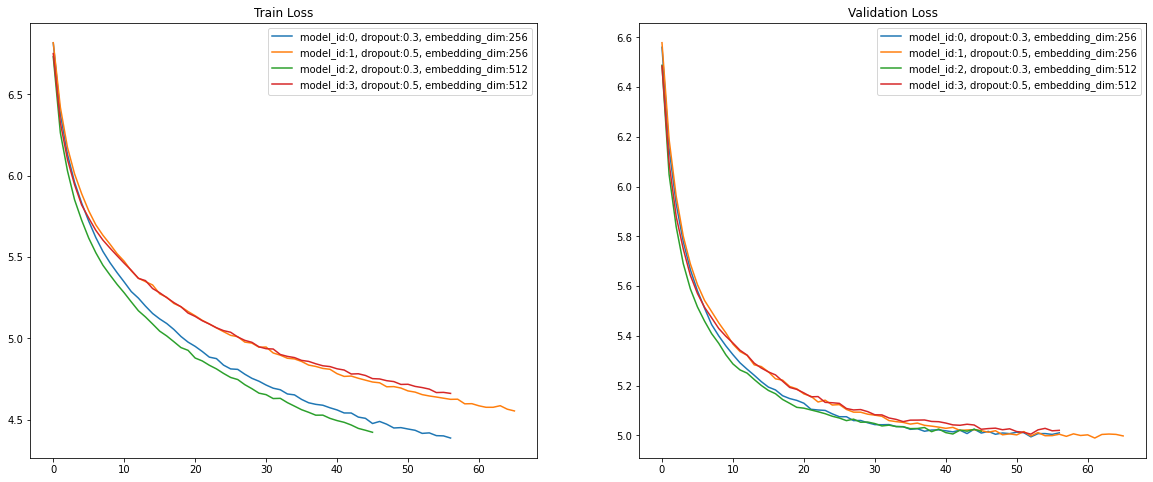

In [22]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
for i in range(4):
    label = f"model_id:{i}, dropout:{model_options[i]['rnn_dropout']}, embedding_dim:{model_options[i]['embedding_dim']}"
    ax1.plot([loss[0] for loss in model_loss[i]], label = label)
    ax2.plot([loss[1] for loss in model_loss[i]], label = label)
    ax1.legend()
    ax2.legend()
    ax1.set_title("Train Loss")
    ax2.set_title("Validation Loss")

plt.show()

Conclusion: 
- From the plot, we can see that model_1 gives us the lowest validation loss, so we choose this model as our optimal model to solve next 2 questions.

---
### 2 Learned embeddings
Next you will analyze the word embeddings that the model learns.

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [ ]:
!pip install umap-learn

In [ ]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'close']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
#best model:
best_model = models[1]

#### 2.1 Word similarity 

In [ ]:
def cosine_similarity(word1, word2):
    norm_1, norm_2 = np.sqrt(np.sum(np.power(word1, 2))), np.sqrt(np.sum(np.power(word2, 2)))
    return np.dot(word1, word2)/(norm_1 * norm_2)

In [ ]:
embedding = best_model.state_dict()['projection.weight']

def find_words(weight_matrix, words):
    weights = weight_matrix.detach().cpu().numpy()
    close_word, far_word = {}, {}
    for i in words:
        all_score = []
        word_id = wiki_dict.get_id(i)
        unk_id = wiki_dict.get_id('<unk>')
        pad_id = wiki_dict.get_id('<pad>')
        for other_idx in range(weights.shape[0]):
            if other_idx != word_id and other_idx != unk_id and other_idx != pad_id:
                score = cosine_similarity(weights[word_id], weights[other_idx])
            else:
                score = 0
            all_score.append(score)
        close_10 = sorted(all_score, reverse=True)[:10]
        far_10 = sorted(all_score)[:10]
        close_id, far_id = [], []
        for j in range(10):
            close_id.append(all_score.index(close_10[j]))
            far_id.append(all_score.index(far_10[j]))
        close_word[i], far_word[i] = close_id, far_id
    return close_word, far_word

In [ ]:
embedding = best_model.state_dict()['projection.weight']

words = ['quick', 'president', 'election', 'summer', 'American']
word_ids = [wiki_dict.get_id(i) for i in words]
close, far = find_words(embedding, words)

for i in close.keys():
    print(i, "closest words:",[wiki_dict.get_token(i) for i in close[i]], 
        "\n\tfarthest words:",[wiki_dict.get_token(i) for i in far[i]])

quick closest words: ['tight', 'blank', 'grenade', 'desperate', 'bayonet', 'touchdown', 'motor', 'hamstring', 'telegram', 'shells'] 
	farthest words: ['Buildings', 'Lives', 'Sciences', 'Unas', 'Propaganda', 'Fathers', 'Monastery', 'lends', 'Savery', 'Altarpiece']
president closest words: ['director', 'chairman', 'manager', 'President', 'captain', 'editor', 'Prime', 'Governor', 'governor', 'Minister'] 
	farthest words: ['kDa', 'piracy', 'nifurtimox', 'OH', 'Characteristics', 'XeO', 'ernst', 'Buteo', 'metabolic', 'semilibera']
election closest words: ['elections', 'event', 'decision', 'pay', 'future', 'Draft', 'campaign', 'act', 'conference', 'newspaper'] 
	farthest words: ['ash', 'Calostoma', '133Xe', 'ara', 'pea', 'raisins', 'fibreglass', 'spruce', 'gastrointestinal', 'apples']
summer closest words: ['winter', 'spring', 'fall', 'general', 'mid', 'fourth', 'competition', 'middle', 'days', 'months'] 
	farthest words: ['Rex', 'Mineral', 'Nergal', 'geographer', 'Christophe', 'Agni', 'Akiko

#### 2.2 UMAP

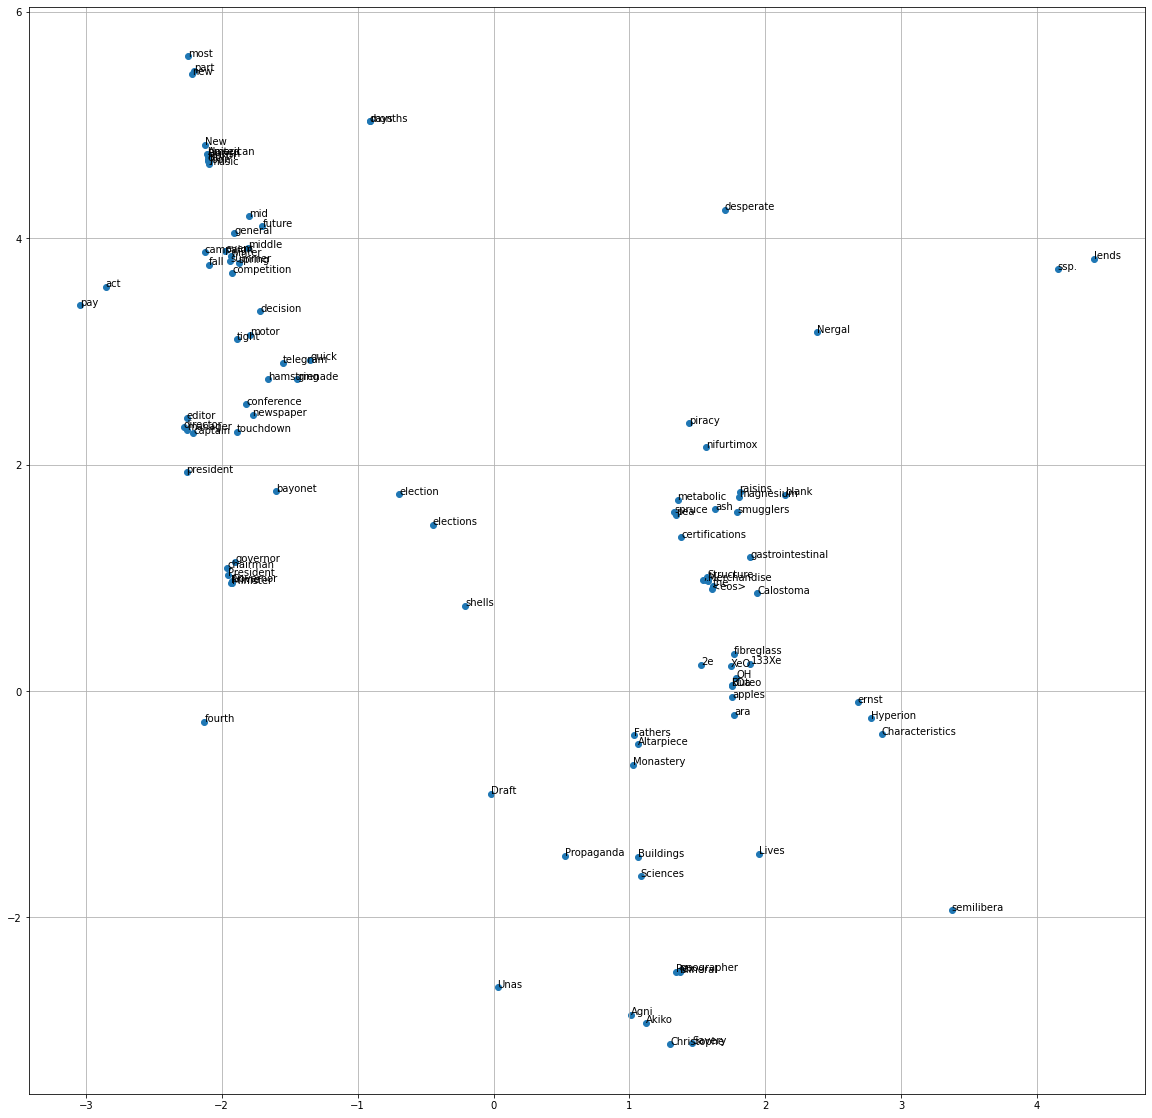

In [ ]:
for i in close.keys():
    word_ids = word_ids + close[i] + far[i]
    words = words + [wiki_dict.get_token(i) for i in close[i]] + [wiki_dict.get_token(i) for i in far[i]]                 # e.g. use dictionary.get_id on a list of words

umap_plot(embedding, word_ids, words)

---
### 3 Sampling


#### 3.1 Sampling implementation 

In [23]:
#best model
best_model = models[1]
options = model_options[1]

In [32]:
start_id = wiki_dict.get_id('<bos>')
input = torch.tensor(start_id, dtype=torch.long).view(1, -1).to(device)
h_t = best_model.init_state(batch_size = 1)
seq = ['<bos>']
best_model.eval()
new_word = ''
with torch.no_grad():
    while new_word != '<eos>':
        out, h_t = best_model(input, h_t)
        softmax = nn.Softmax(dim=1)
        p = softmax(out)
        input = torch.multinomial(p, 1)
        new_word = wiki_dict.get_token(input.item())
        seq.append(new_word)
seq

['<bos>',
 'Flechas',
 'Fort',
 'carbonaria',
 'the',
 'war',
 ',',
 'Bragg',
 'and',
 'convinced',
 'to',
 'ordnance',
 'three',
 'years',
 'after',
 'Magadheera',
 ',',
 'She',
 'had',
 'an',
 'old',
 'Ingres',
 'had',
 'had',
 'been',
 'the',
 'Berlin',
 'General',
 'Basuki',
 'This',
 'engraver',
 'John',
 'Training',
 'Astronomical',
 'Rimmer',
 'He',
 'was',
 'was',
 'moved',
 'to',
 'the',
 'Canadian',
 'A',
 '+',
 '48',
 'December',
 ',',
 'During',
 'the',
 'sometimes',
 'Gwen',
 '"',
 'It',
 'began',
 'to',
 'the',
 'breaking',
 'the',
 'meeting',
 'for',
 'the',
 '$',
 '25',
 '–',
 '99',
 '<eos>']

#### 3.2 1,000 samples and average log probability implementation

In [25]:
total_log_prob = 0
samples = []
best_model.eval()
with torch.no_grad():
    for i in range(1000):
        start_id = wiki_dict.get_id('<bos>')
        input = torch.tensor(start_id, dtype=torch.long).view(1, -1).to(device)
        h_t = best_model.init_state(batch_size = 1)
        log_prob = 0
        seq = ['<bos>']
        while wiki_dict.get_token(input.item()) != '<eos>':
            out, h_t = best_model(input, h_t)
            softmax = nn.Softmax(dim=1)
            p = softmax(out)
            input = torch.multinomial(p, 1)
            new_word = wiki_dict.get_token(input.item())
            seq.append(new_word)
            log_prob += torch.log(p[0][input.item()])
        samples.append(seq)
        total_log_prob += log_prob

avg_log_prob = total_log_prob/1000
print(avg_log_prob)

tensor(-323.0096, device='cuda:0')


#### 3.3 Number of unique tokens and sequence length

(1,000 samples vs. 1,000 randomly selected validation-set sequences)


In [26]:
from numpy import random
from collections import Counter

In [27]:
from numpy import random
valid_size = len(datasets['valid'])
valid_idx = random.choice(range(valid_size), size=(1000), replace=False)
valid_seq = [datasets['valid'][i] for i in valid_idx]

In [28]:
sample_avg_len = np.mean([len(i) for i in samples])
valid_avg_len = np.mean([len(i) for i in valid_seq])
print("average sequence length: validation set {}, sampled sequences {}".format(valid_avg_len, sample_avg_len))

average sequence length: validation set 23.52, sampled sequences 59.767


In [29]:
flattened_sample_seq = [word for sample in samples for word in sample]
flattened_valid_seq = [word for seq in valid_seq for word in seq]
sample_uniq_tokens = len(Counter(flattened_sample_seq).keys())
valid_uniq_tokens = len(Counter(flattened_valid_seq).keys())
print("total unique tokens: validation set {}, sampled sequences {}".format(valid_uniq_tokens, sample_uniq_tokens))

total unique tokens: validation set 5070, sampled sequences 9748


#### 3.4 Example samples

In [31]:
sample_sequences_3 = [' '.join(sample) for sample in samples[-3:]]
sample_sequences_3

['<bos> Following these years later counted the Owls , N. As a man , I. They use of Independence \'s and NBA Gold and began , Reformed On 16 men produced the Song Hotel Historic Society , although she kept confusion filled with the contemporary , where " As a shaft Eventually her husband recorded : <eos>',
 '<bos> The New York was as the seven listed on the situation Fowler manager Michael Jackson led to his need made the sinks in 1978 , and Jiankang I am The ABC for <unk> At the theft and St Andrew replaced the overseer , In the project , the cause his Japanese <unk> A Warner Public MTV Tech score , The New Zealand The Star Creek , while Christine Three one point : Harkuf Federer remastered However , " The Simpsons Jordan Together to the play <unk> and co @-@ based on the Frankish Florida and full success a DC @-@ 38 ° Highway 0 <eos>',
 '<bos> " In the <unk> al. Ingres was comprised The Illustrated Somerset went for the spotlight The Simpsons , Washington World War while Aquilops In 